# Examples: `image` 

In [1]:
import sys
sys.path.append('..')

from ipywidgets import interact
from ipywidgets import widgets
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import psdist.bunch as psd
import psdist.image as psi
import psdist.plotting as psp
from psdist import utils
import scipy.ndimage

In [2]:
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['grid'] = False

## 2D image 

In [3]:
res = 50
state = np.random.RandomState(1951)
xx = np.linspace(-5.0, 5.0, res)
X, Y = np.meshgrid(xx, xx, indexing='ij')
f = np.zeros((res, res))
for _ in range(4):
    sig = state.uniform(0.5, 1.5, size=2)
    mu = state.uniform(-2.0, 2.0, size=2)
    f += np.exp(-0.5 * (((X - mu[0]) / sig[0])**2 + ((Y - mu[1]) / sig[1])**2))
f = f + 0.01 * np.max(f)
f = f / np.max(f)

In [4]:
@interact(thresh=(-5.0, 0.0), log=False, discrete=False)
def update(log, discrete, thresh):
    fig, ax = pplt.subplots()
    ax = psp.image(
        f, x=xx, y=xx, ax=ax,
        profx=True, profy=True,
        thresh=10.0**thresh, 
        rms_ellipse=True, 
        rms_ellipse_kws=dict(color='white'), 
        colorbar=True,
        norm=('log' if log else None),
        vmax=1.0,
        discrete=discrete,
    )

interactive(children=(Checkbox(value=False, description='log'), Checkbox(value=False, description='discrete'),…

## ND image 

In [5]:
res = 50
n = 4
dims = ["x", "x'", "y", "y'"]
pairs = [(i, j) for i in range(n) for j in range(i)]

shape = tuple(n * [res])
xmax = 5.0
coords = n * [np.linspace(-xmax, xmax, res)]
COORDS = np.meshgrid(*coords, indexing='ij')
R = np.sqrt(np.sum([C**2 for C in COORDS], axis=0))

# Start with gaussian * cosine
f = 0.25 * np.exp(-0.5 * (R / 2.0)) * np.cos(3.0 * R)**2
f[R > 4.0] = 0.0
for _ in range(10):
    # Generate a Gaussian distribution with random mean and std.
    sig = state.uniform(0.5, 1.0, size=n)
    mu = state.uniform(-3.0, 3.0, size=n)
    argument = np.zeros(shape)
    for i in range(n):
        argument += ((COORDS[i] - mu[i]) / sig[i])**2
    # Add random linear correlations.
    for (i, j) in pairs:
        r = state.uniform(-0.75, 0.75)
        U = (COORDS[i] - mu[i]) / sig[i]
        V = (COORDS[j] - mu[j]) / sig[j]
        argument += r * U * V
    f += np.exp(-0.5 * argument)    
f = f / np.max(f)
f[f < 0.001] = 0.0

### Corner plot 

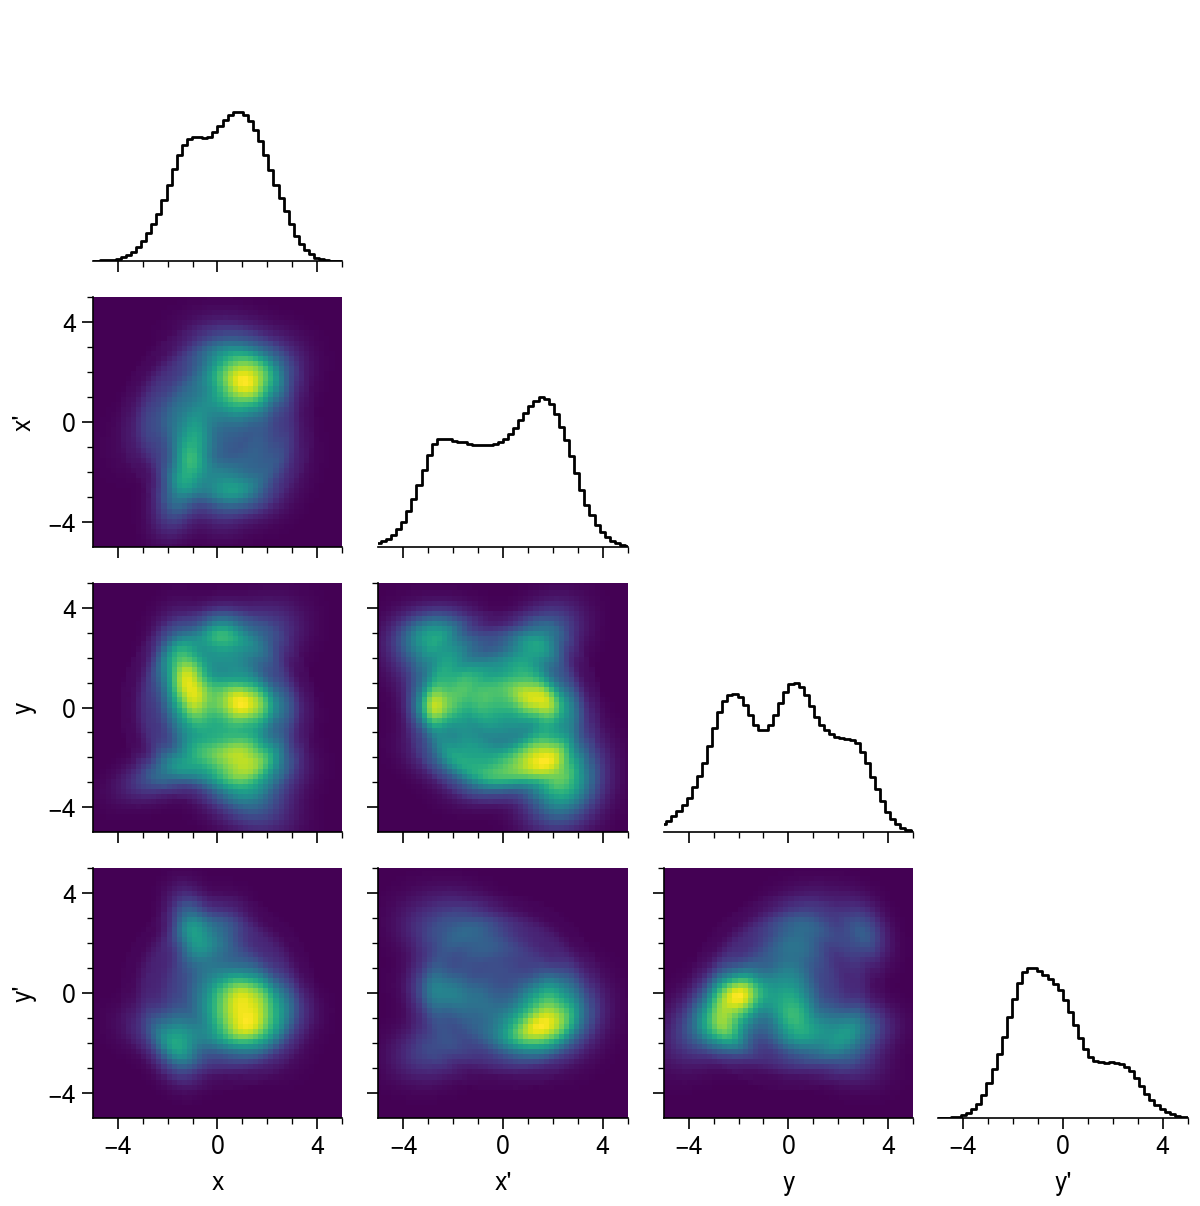

In [6]:
axs = psp.corner(
    data=f,
    coords=coords,
    diag_kind='step',
    prof=False,
    labels=dims,
    # rms_ellipse=True,
    rms_ellipse_kws=dict(color='white', alpha=0.35, level=2.0),
    norm=None
)

### Slice matrix

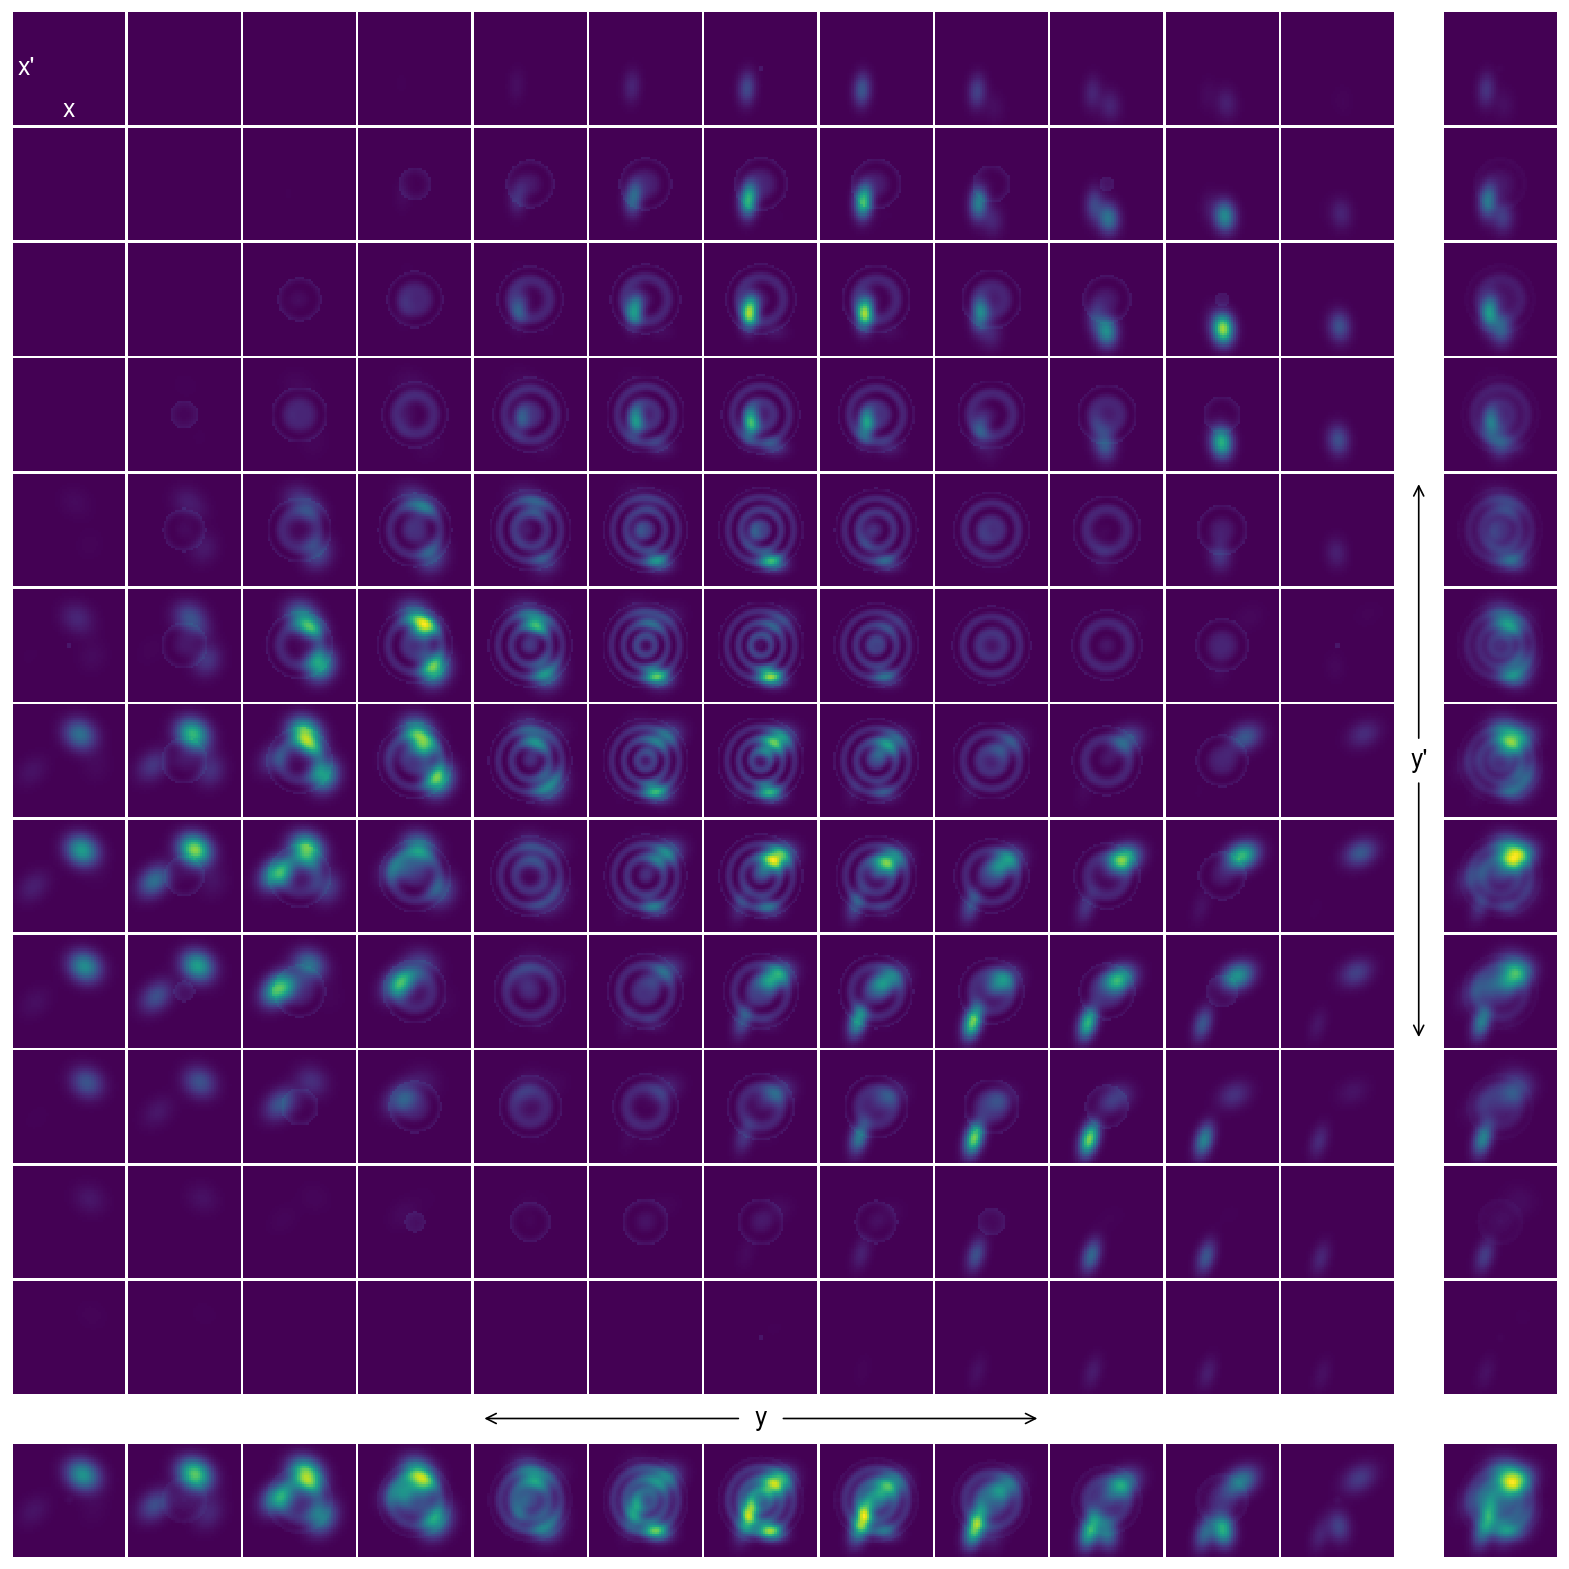

In [7]:
axs = psp.slice_matrix(
    f, 
    axis_view=(0, 1),
    axis_slice=(2, 3), 
    nrows=12, ncols=12, 
    coords=coords, 
    dims=dims, 
    pad=0.1,
    vmax=1.0  # share same vmax for all plots.
)

### 1D projection with interactive slicing

In [8]:
psp.interactive_proj1d(f, coords=coords, dims=dims)

interactive(children=(Dropdown(description='dim', options=('x', "x'", 'y', "y'"), value='x'), Checkbox(value=F…

### 2D projection with interactive slicing

In [9]:
psp.interactive_proj2d(f, coords=coords, dims=dims)

interactive(children=(Dropdown(description='cmap', options=('viridis', 'dusk_r', 'mono_r', 'plasma'), value='v…

### Contour slices

#### 1D projection, 4D contour slice

Here, we observe the 1D projection of the distribution within a 4D contour slice in the other dimensions.

In [10]:
@interact(
    dim=widgets.Dropdown(options=dims, value=dims[0]),
    levels=widgets.FloatRangeSlider(
        description='4D thresh', min=0.0, max=1.0, value=(0.0, 1.0), step=0.001,
        continuous_update=True,
    ),
)
def update(dim, levels):
    lmin, lmax = levels
    axis = dims.index(dim)
    proj = psi.project1d_contour(f, axis=axis, lmin=lmin, lmax=lmax)
    
    fig, ax = pplt.subplots(figsize=(4, 1.5))
    ax.format(xlabel=dims[axis])
    psp.lineplot(coords[axis], proj, ax=ax, kind='step', color='black')
    plt.show()

interactive(children=(Dropdown(description='dim', options=('x', "x'", 'y', "y'"), value='x'), FloatRangeSlider…

We can do the same thing with a 2D projection of the distribution within a 3D contour slice in the other dimensions.

In [11]:
@interact(
    dim1=widgets.Dropdown(options=dims, value=dims[0]),
    dim2=widgets.Dropdown(options=dims, value=dims[1]),
    levels=widgets.FloatRangeSlider(
        description='3D thresh', min=0.0, max=1.0, value=(0.0, 1.0), step=0.001, 
        readback_format='.3f',
    ),
    log=False,
)
def update(levels, dim1, dim2, log, **plot_kws):
    if dim1 == dim2:
        return
    axis = (dims.index(dim1), dims.index(dim2))
    lmin, lmax = levels
    proj = psi.project2d_contour(f, axis=axis, lmin=lmin, lmax=lmax)
    
    fig, ax = pplt.subplots()
    plot_kws['norm'] = 'log' if log else None
    plot_kws.setdefault('thresh', 10.0**-3.0)
    plot_kws.setdefault('thresh_type', 'frac')
    plot_kws.setdefault('colorbar', True)
    plot_kws.setdefault('profx', True)
    plot_kws.setdefault('profy', True)
    plot_kws.setdefault('floor', 1.0 if log else None)
    ax.format(xlabel=dims[axis[0]], ylabel=dims[axis[1]])
    psp.image(proj, x=coords[axis[0]], y=coords[axis[1]], ax=ax, colorbar=True)
    ax.format(xlim=sorted(ax.get_xlim()))
    plt.show()

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), description='3D thresh', max=1.0, step=0.001), Dropdo…

## Sampling

Treat the image as a histogram; sample uniformly within each bin.

In [12]:
X = psi.sample_grid(f, coords, samples=1000)

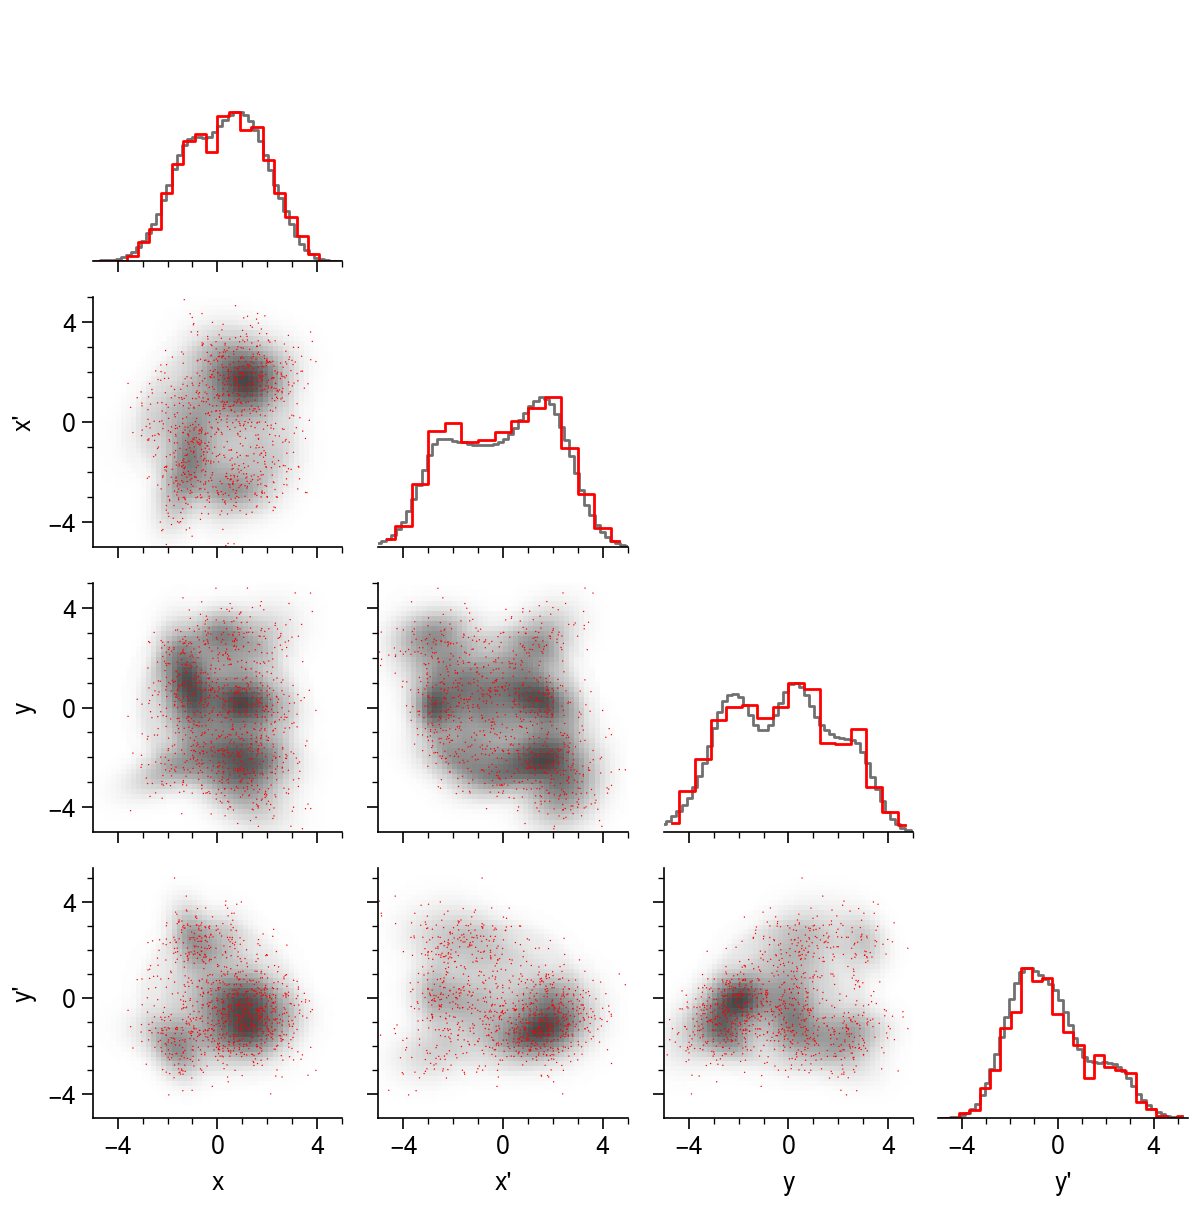

In [13]:
cmap = pplt.Colormap('mono', left=0.0, right=0.7)

axs = psp.corner(
    data=f,
    coords=coords,
    diag_kind='step',
    prof=False,
    labels=dims,
    cmap=cmap,
    diag_kws=dict(color=cmap(0.75))
)
color = 'red'
psp.corner(
    data=X,
    axes=axs,
    kind='scatter',
    diag_kws=dict(color=color),
    s=1, color=color,
)
plt.show()

In [14]:
X = psi.sample_grid(f, coords, samples=int(1e5))

In [15]:
Sigma_image = psi.cov(f, coords)
print(Sigma_image)

[[ 2.39020082  0.73549997 -0.29871915 -0.19150569]
 [ 0.73549997  4.22758789 -1.4506152  -0.81356451]
 [-0.29871915 -1.4506152   4.451758    0.51486469]
 [-0.19150569 -0.81356451  0.51486469  2.81636696]]


In [16]:
Sigma_bunch = np.cov(X.T)
print(Sigma_bunch)

[[ 2.37423132  0.72755744 -0.27925507 -0.18055458]
 [ 0.72755744  4.23272904 -1.43253944 -0.82677142]
 [-0.27925507 -1.43253944  4.44321263  0.51265187]
 [-0.18055458 -0.82677142  0.51265187  2.80054008]]
